In [63]:
import sys

import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

sys.path.append("..")
import global_vars as gv
from model_config import all_model_setting_base_v1 as mconfig
from utils import model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
#### read in data
test_df = pd.read_csv("../data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv("../data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv("../data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [42]:
feature_dict = {
    "log_temp_pca_onehot_impute_rf": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "log_temp_pca_onehot_impute_xgb": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "log_temp_pca_onehot_xgb": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
}

<IPython.core.display.Javascript object>

In [43]:
config_name = "log_temp_pca_onehot_xgb"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]
model = xgb.XGBRegressor()
# model = RandomForestRegressor(max_depth=2, random_state=0)
# features_columns = mconfig[config_name]["features"]
# model = mconfig[config_name]["model"]
# if_scale = mconfig[config_name]["if_scale"]

<IPython.core.display.Javascript object>

Fitting PCA with 9 components


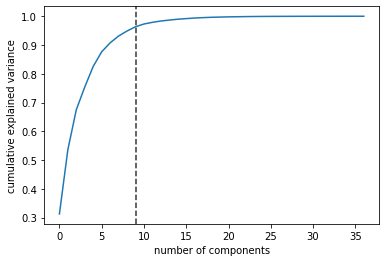

<IPython.core.display.Javascript object>

In [51]:
train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates(),
    test_df.drop_duplicates(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

In [52]:
train_filter_df = train_filter_df#.drop(columns = ["energy_star_rating"])
print(train_filter_df.shape)

(75757, 36)


<IPython.core.display.Javascript object>

In [53]:
train_filter_df.filter(like="energy_star_rating").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_star_rating  49048 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


<IPython.core.display.Javascript object>

In [54]:
# Set feature columns after data transformations
features_columns = (
    list(set(gv.all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
    + pca_cols
    + [f"log10_{col}" for col in log10_transform_cols]
)
if backfill_dict:
    backfill_cols = list(backfill_dict.keys())
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
print(config_name, features_columns, if_one_hot)

log_temp_pca_onehot_xgb ['days_above_80f', 'precipitation_inches', 'energy_star_rating', 'days_above_100f', 'days_below_10f', 'days_above_110f', 'days_below_30f', 'heating_degree_days', 'direction_max_wind_speed', 'building_class', 'days_with_fog', 'snowfall_inches', 'snowdepth_inches', 'facility_type', 'cooling_degree_days', 'max_wind_speed', 'days_above_90f', 'direction_peak_wind_speed', 'days_below_0f', 'state_factor', 'days_below_20f', 'elevation', 'year_built', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'log10_floor_area'] True


<IPython.core.display.Javascript object>

In [55]:
len(features_columns)

33

<IPython.core.display.Javascript object>

In [56]:
print(train_filter_df.shape)
# train_filter_df = train_filter_df.dropna(how="any")
print(train_filter_df.shape)

(75757, 36)
(75757, 36)


<IPython.core.display.Javascript object>

In [57]:
rf_rmse = mu.run_leave_year_out(
    model_df=train_filter_df,
    ml_model=model,
    features_columns=features_columns,
    if_scale_data=if_scale,
    if_one_hot=if_one_hot,
    model_type="sklearn",
)
print(f"Average RMSE:\n{rf_rmse.mean()}")
display(rf_rmse)

Running sklearn
Modeling 1...
Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Modeling 2...
Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Modeling 3...
Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Modeling 4...
Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Modeling 5...
Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Modeling 6...
Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Average RMSE:
left_out_year     3.500000
train_rmse       33.227805
test_rmse        47.111875
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,33.126816,58.616800
1,2,32.715482,47.001338
2,3,31.604915,47.785573
3,4,33.626838,42.343938
4,5,34.341132,40.990454
5,6,33.951648,45.933148


<IPython.core.display.Javascript object>

In [60]:
## predict on test data
train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
    train_filter_df, features_columns
)
test_filter_x_df = mu.split_model_feature_response(
    test_filter_df, features_columns, if_with_response=False
)
processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
        train_filter_x_df, test_filter_x_df, if_scale, if_one_hot, train_filter_df
    )
train_predict, test_predict, fitted_model = mu.run_sklearn_model(
    model, processed_train_x_df, train_filter_y_df, processed_test_x_df
)
training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
print(f"Whole data train RMSE: {training_rmse}")

## output save result
# test_prediction_result = test_df[["id"]]
# test_prediction_result["site_eui"] = test_predict
# test_prediction_result.head()
# test_prediction_result.to_csv(f"../prediction_result/{config_name}.csv", index=False)


Columns to be dummied: ['facility_type', 'building_class', 'state_factor']
Whole data train RMSE: 33.63828943522524


<IPython.core.display.Javascript object>

In [61]:
fitted_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

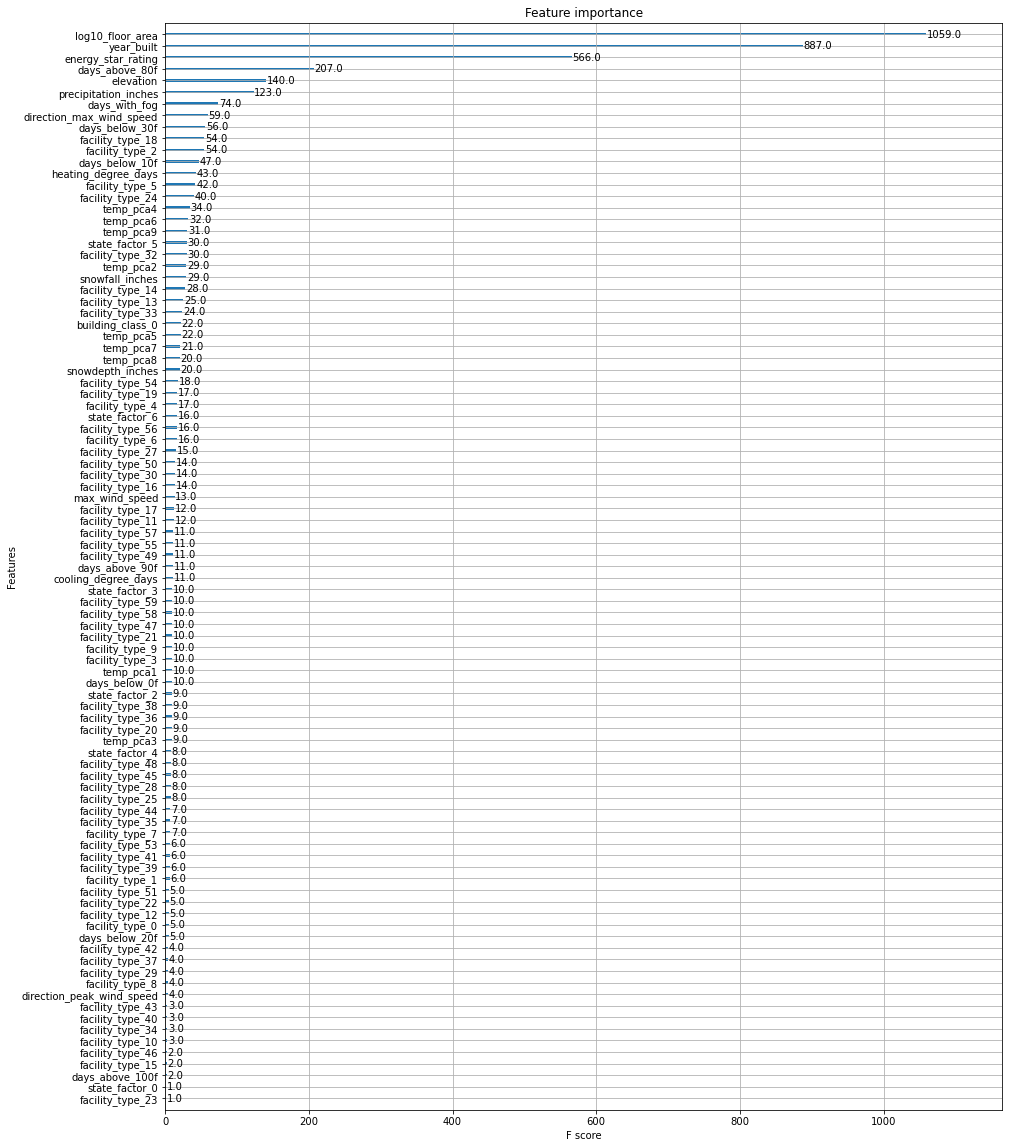

<IPython.core.display.Javascript object>

In [65]:
fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(fitted_model, ax=ax)
plt.show()